In [2]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from bids import BIDSLayout
import mne_bids
import settings
import json
from coordinates_io import BIDS_coord
from sklearn import linear_model
import multiprocessing
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

In [3]:
out_path = '/home/icn/Documents/raw_out/raw_combined/'

In [4]:
subject_id = '000'

In [5]:
with open(out_path+'sub_'+subject_id+'_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

In [6]:
dict_ch.keys()

dict_keys(['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'STN_RIGHT_3'])

In [15]:
dict_ch[list(dict_ch.keys())[0]].keys()

dict_keys(['data', 'true_movements', 'mov_ch', 'choords', 'res_MOV_RIGHT', 'res_MOV_LEFT'])

In [22]:
movements_channel =  [mov for mov in list(dict_ch[channels[0]].keys()) if mov.startswith('res_MOV')]

In [23]:
movements_channel

['res_MOV_RIGHT', 'res_MOV_LEFT']

In [25]:
dict_ch[channels[0]][movements_channel[0]]["R2"]

0.14347507915946361

In [26]:
dict_ch[channels[0]][movements_channel[0]]

{'R2': 0.14347507915946361,
 'weight_MOV_RIGHT': [-0.11921310360874146,
  -0.20942463787194535,
  -0.3025098198201777,
  -0.056103066432295866,
  -0.0657996399720697,
  0.3126802886699624,
  -0.19175371805518734,
  -0.6001575452538882]}

In [17]:
dict_ch[channels[0]]["choords"][0]

NameError: name 'channels' is not defined

In [31]:
#plot: run through all channels per Patient and plot the res vals +
# if STN is True: 
ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]

In [32]:
ind_ECOG

[0, 1, 2, 3, 4, 5]

In [7]:
# setup plot where STN and ECOG is visible 
faces = io.loadmat('faces.mat')
Vertices = io.loadmat('Vertices.mat')
grid = io.loadmat('grid.mat')['grid']
stn_surf = io.loadmat('STN_surf.mat')

In [ ]:
def plot_STN_with_grid(x_grid, y_grid, coords_x, coords_y, val, clim_low, clim_high):
    plt.scatter(x_grid, y_grid, c='gray', s=0.25, alpha='0.5')
    plt.axis('off')
    plt.scatter(coords_x, coords_y, c = val, s = 30, alpha=1)
    cbar = plt.colorbar()
    plt.clim(clim_low, clim_high)
    cbar.remove()
    plt.axis('equal')

In [8]:
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]

In [9]:
channels = list(dict_ch.keys())

In [16]:

ind_STN_ch = ind_STN[0]


In [25]:
channels = list(dict_ch.keys())
ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]


In [28]:
choord[0]

11.8280802308701

In [29]:
choord[1]

-15.1597482742092

In [30]:
c

0.015954750848677056

In [60]:
def get_x_y_c(ind_):
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[0]]["R2"]
    return x_choord, y_choord, c_

In [59]:
ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]

In [62]:
x,y,c = get_x_y_c(ind_STN)

(11.746434067034297,
 13.526221953381299,
 -15.292665558210711,
 -12.393779644246587)

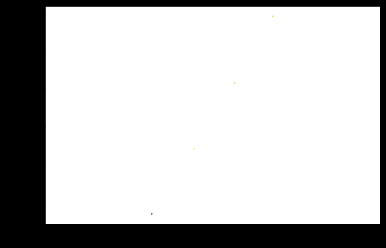

In [66]:
plt.figure(facecolor=(0,0,0))
plt.scatter(x_choord, y_choord, c=c_, s=0.25)
plt.axis("equal")

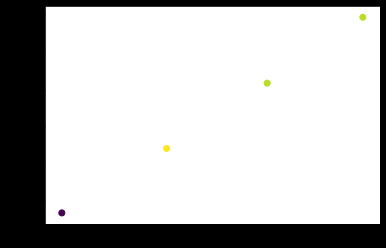

In [57]:
#ax = fig.add_subplot(111, facecolor=(0,0,0))
#fig.canvas.draw()

plt.figure(facecolor=(0,0,0))
plt.

plt.scatter(x_choord, y_choord, c=c_)

#ax.autoscale(True)

In [49]:
x_choord.shape

(4,)

In [51]:
y_choord.shape

(4,)

In [52]:
c_.shape

(4,)

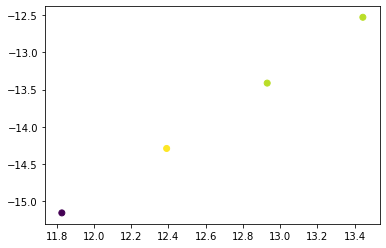

In [53]:
plt.scatter(x_choord, y_choord, c=c_)